# An analysis of the State of the Union speeches - Part 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [2]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [3]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [4]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [5]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

def clean_word_tokenize(doc):
    """custom word tokenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    stop = stopwords.words('english') + list(string.punctuation)
    tokens = [i.lower() for i in word_tokenize(doc) if i not in stop]
    return(tokens)


In [6]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# find the stem of word tokenizer, remove stop words and punctuation.
def stem_word_tokenize(doc):
    stop = stopwords.words('english') + list(string.punctuation)
    tokens = [stemmer.stem(i.lower()) for i in word_tokenize(doc) if i not in stop]
    return(tokens)

In [7]:
from collections import Counter
from nltk import sent_tokenize

#some calculations to get the numbers of words, sentences, chars.
n_sent = [len(sent_tokenize(sent)) for sent in speeches]
n_words_all = [len(word_tokenize(word)) for word in speeches]
n_words = [len(clean_word_tokenize(speech)) for speech in speeches]
n_uwords = [len(Counter(clean_word_tokenize(speech))) for speech in speeches]
n_swords = [len(Counter(stem_word_tokenize(speech))) for speech in speeches]
n_chars = [len(speech) for speech in speeches]

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [8]:
#save the number into dataframe.
addresses['n_sent'] = n_sent
addresses['n_words_all'] = n_words_all
addresses['n_words'] = n_words
addresses['n_uwords'] = n_uwords
addresses['n_swords'] = n_swords
addresses['n_chars'] = n_chars
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24,1178,538,395,356,6753
1,George Washington,State of the Union Address,1790-12-08,40,1515,683,513,461,8455
2,George Washington,State of the Union Address,1791-10-25,60,2487,1136,731,622,14203
3,George Washington,State of the Union Address,1792-11-06,61,2298,1042,682,578,12764
4,George Washington,State of the Union Address,1793-12-03,56,2132,972,714,652,11696


Let's look at a summary of these 

In [9]:
pd.options.display.precision = 2
addresses.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1639.84,1279.88,45473.15
std,178.80,5871.69,2900.51,747.67,499.96,33020.36
min,24.00,1059.00,538.00,395.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1088.50,909.00,23394.50
50%,240.00,6655.00,3388.00,1530.00,1236.00,36677.00
75%,347.50,10055.00,4801.50,1998.50,1538.00,55211.00
max,1343.00,36974.00,21041.00,4282.00,2966.00,218009.00


## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

In [10]:
from math import *
pd.options.display.precision = 6
addresses['log_n_words'] = [log(word,e) for word in addresses['n_words'].values]
addresses['log_n_sent'] = [log(sent,e) for sent in addresses['n_sent'].values]
addresses['vocab_per_word'] = addresses['n_uwords'] / addresses['n_words']
addresses['word_per_sent'] = addresses['n_words'] / addresses['n_sent']
addresses['char_per_word'] = addresses['n_chars'] / addresses['n_words']
addresses['frac_stop'] = (addresses['n_words_all'] / addresses['n_words']) - 1

In [11]:
#Set up the dataframe for seaborn plot.
addresses_melt = addresses.melt('date',['log_n_sent','log_n_words','vocab_per_word','word_per_sent','char_per_word','frac_stop'])

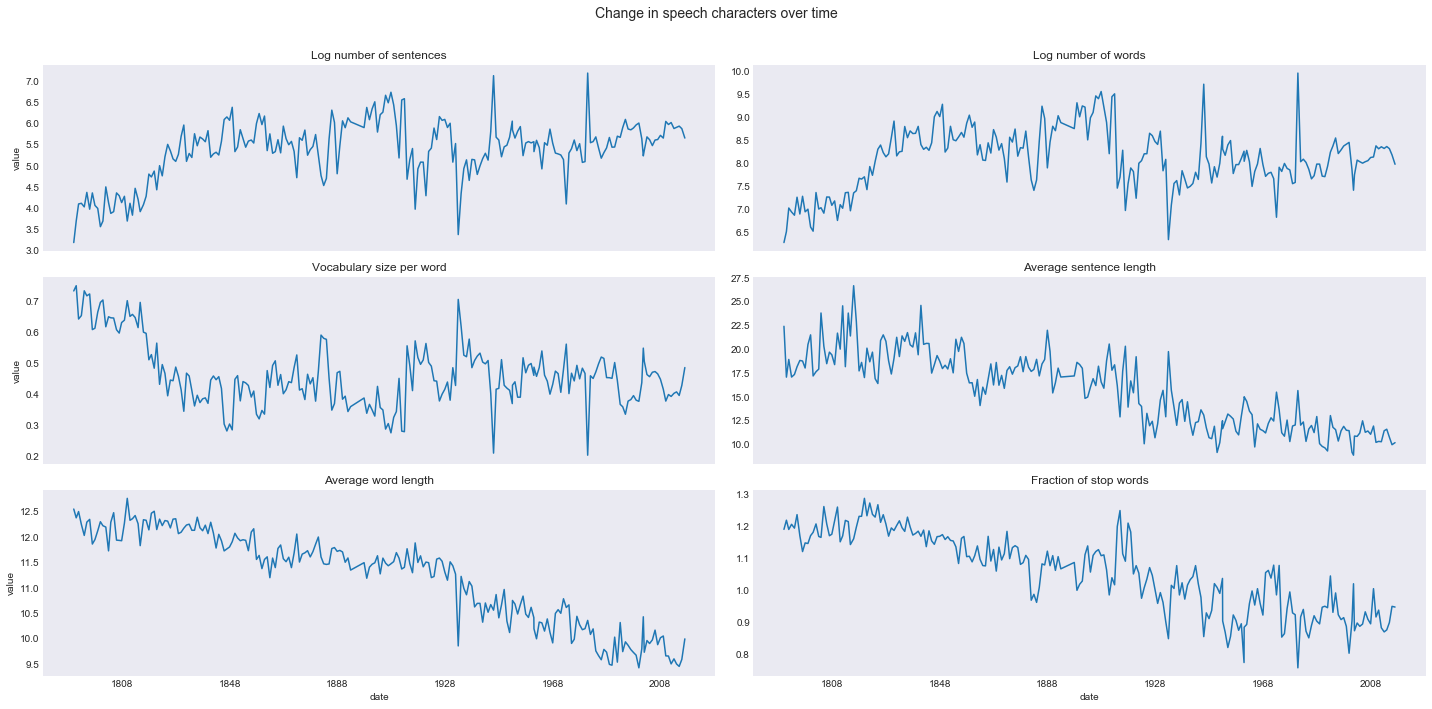

In [12]:
g = sns.FacetGrid(addresses_melt,col = 'variable', col_wrap = 2, sharey=False)
g.fig.suptitle('Change in speech characters over time', fontsize=14)
g.map(plt.plot,'date','value')
g.fig.set_size_inches(20,10)
g.fig.tight_layout(w_pad=1.5)
ax = g.axes.flatten()
ax[0].set_title('Log number of sentences')
ax[1].set_title('Log number of words')
ax[2].set_title('Vocabulary size per word')
ax[3].set_title('Average sentence length')
ax[4].set_title('Average word length')
ax[5].set_title('Fraction of stop words')
plt.subplots_adjust(top=0.9)

# Use Seaborn to provide a plot such as this, and discuss:
plt.savefig("fig/speech_changes.png")

Now for the distributions by president

In [13]:
#setup the dataframe for seaborn plot.
addresses_pre_melt = addresses.melt('president',['log_n_sent','log_n_words','vocab_per_word','word_per_sent','char_per_word','frac_stop'])

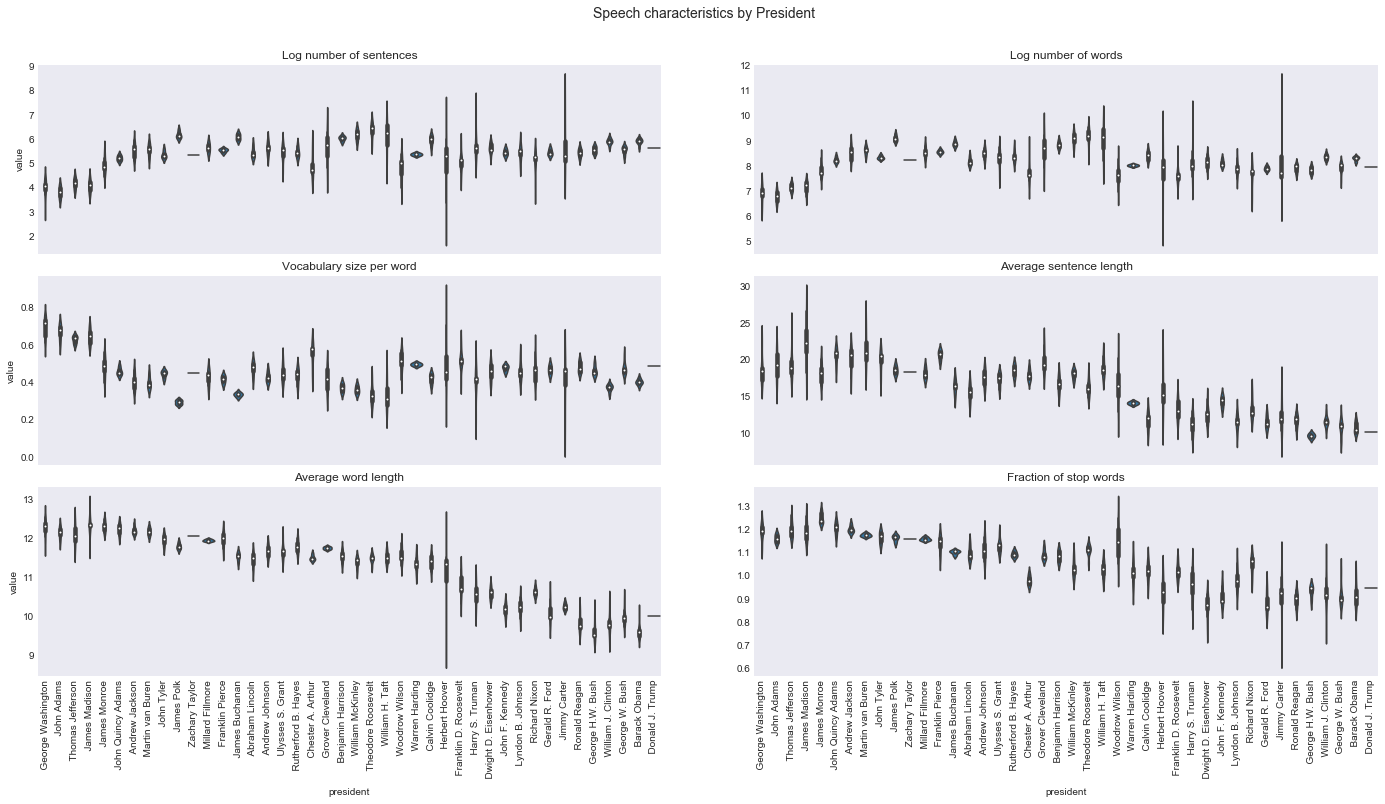

In [14]:
g = sns.FacetGrid(addresses_pre_melt,col = 'variable', col_wrap = 2, sharey=False)
g.fig.suptitle('Speech characteristics by President', fontsize=14)
g.map(sns.violinplot,'president','value')
g.fig.set_size_inches(20,10)
g.fig.tight_layout(w_pad=1.5)
ax = g.axes.flatten()
ax[0].set_title('Log number of sentences')
ax[1].set_title('Log number of words')
ax[2].set_title('Vocabulary size per word')
ax[3].set_title('Average sentence length')
ax[4].set_title('Average word length')
ax[5].set_title('Fraction of stop words')
plt.subplots_adjust(top=0.9)
g.set_xticklabels(rotation=90)

# YOUR CODE HERE
plt.savefig("fig/speech_characteristics.png");

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [16]:
speech_words = [clean_word_tokenize(word) for word in speeches]
speeches_cleaned = [stem_word_tokenize(speech) for speech in speeches]

In [17]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words
    db['speeches_cleaned'] = speeches_cleaned